# Multiclass Classification of Fashion-MNIST dataset with Pytorch
## Part-1: Training base model

In [1]:
# torchmetrics is not available by default - install it
!pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.2 MB/s eta 0:00:00


In [2]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os
import sys

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    # now add correct module folder to sys.path
    PYTORCH_NOTEBOOKS_PATH = "/content/drive/My Drive/Colab Notebooks/Pytorch"
    assert os.path.exists(PYTORCH_NOTEBOOKS_PATH), f"FATAL: {PYTORCH_NOTEBOOKS_PATH} does not exist!"
    sys.path.insert(0, PYTORCH_NOTEBOOKS_PATH)
    print(f"sys.path: {sys.path}", flush=True)
    assert os.path.exists(os.path.join(PYTORCH_NOTEBOOKS_PATH, "torch_training_toolkit.py")), \
        f"FATAL ERROR: torch_training_toolkit not found!"
    MODEL_SAVE_DIR = os.path.join(PYTORCH_NOTEBOOKS_PATH, "model_states")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')

print(f"Model states will be saved to {MODEL_SAVE_DIR}")

if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)


import torch_training_toolkit as t3

Mounted at /content/drive/
sys.path: ['/content/drive/My Drive/Colab Notebooks/Pytorch', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']
Model states will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states


## Standard Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')

import sys, os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn-v0_8')
sns.set(style='darkgrid', context='notebook', font_scale=1.2)

# Pytorch imports
import torch
print(f'Using Pytorch version {torch.__version__}. ' +
      f'GPU {"is available :)" if torch.cuda.is_available() else "is not available :("}')
import torch.nn as nn
from torchvision import datasets, transforms
import torchmetrics
import torchsummary
# My helper functions for training/evaluating etc.
import torch_training_toolkit as t3

SEED = t3.seed_all()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using Pytorch version 2.1.0+cu121. GPU is available :)


## Helper Functions

In [4]:
def load_data():
    """
    load the data using datasets API. We also split the test_dataset into
    cross-val/test datasets using 80:20 ration
    """
    mean, std = 0.5, 0.5
    transformations = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset =  datasets.FashionMNIST(root='./data', train=True, download=True,
                                   transform=transformations)

    print("No of training records: %d" % len(train_dataset))

    test_dataset = datasets.FashionMNIST('./data', train=False, download=True,
                                  transform=transformations)
    print("No of test records: %d" % len(test_dataset))

    # lets split the test dataset into val_dataset & test_dataset -> 8000:2000 records
    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [8000, 2000])
    print("No of cross-val records: %d" % len(val_dataset))
    print("No of test records: %d" % len(test_dataset))

    return train_dataset, val_dataset, test_dataset

In [5]:
def display_sample(sample_images, sample_labels, grid_shape=(10, 10), plot_title=None,
                   sample_predictions=None):
    # just in case these are not imported!
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('seaborn-v0_8')

    num_rows, num_cols = grid_shape
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.10)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=(14, 10),
            gridspec_kw={"wspace": 0.05, "hspace": 0.35}, squeeze=True)  # 0.03, 0.25
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.90) # 0.93

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index].squeeze(), cmap="Greys", interpolation='nearest')

                if sample_predictions is None:
                    # but show the prediction in the title
                    title = ax[r, c].set_title(f"{FASHION_LABELS[sample_labels[image_index]]}")
                else:
                    pred_matches_actual = (
                                sample_labels[image_index] == sample_predictions[image_index])
                    if pred_matches_actual:
                        # show title from prediction or actual in green font
                        title = '%s' % FASHION_LABELS[sample_predictions[image_index]]
                        title_color = 'g'
                    else:
                        # show title as actual/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[sample_labels[image_index]],
                                           FASHION_LABELS[sample_predictions[image_index]])
                        title_color = 'r'

                    # but show the prediction in the title
                    title = ax[r, c].set_title(title)
                    # if prediction is incorrect title color is red, else green
                    plt.setp(title, color=title_color)

        if plot_title is not None:
            plt.suptitle(plot_title)
        plt.show()
        plt.close()

In [6]:
# (down)load the data
train_dataset, val_dataset, test_dataset = load_data()

100%|██████████| 26421880/26421880 [00:00<00:00, 110416719.69it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5015390.45it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 68469268.36it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4547657.33it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

No of training records: 60000
No of test records: 10000
No of cross-val records: 8000
No of test records: 2000


images.shape = torch.Size([64, 1, 28, 28]), labels.shape=torch.Size([64])


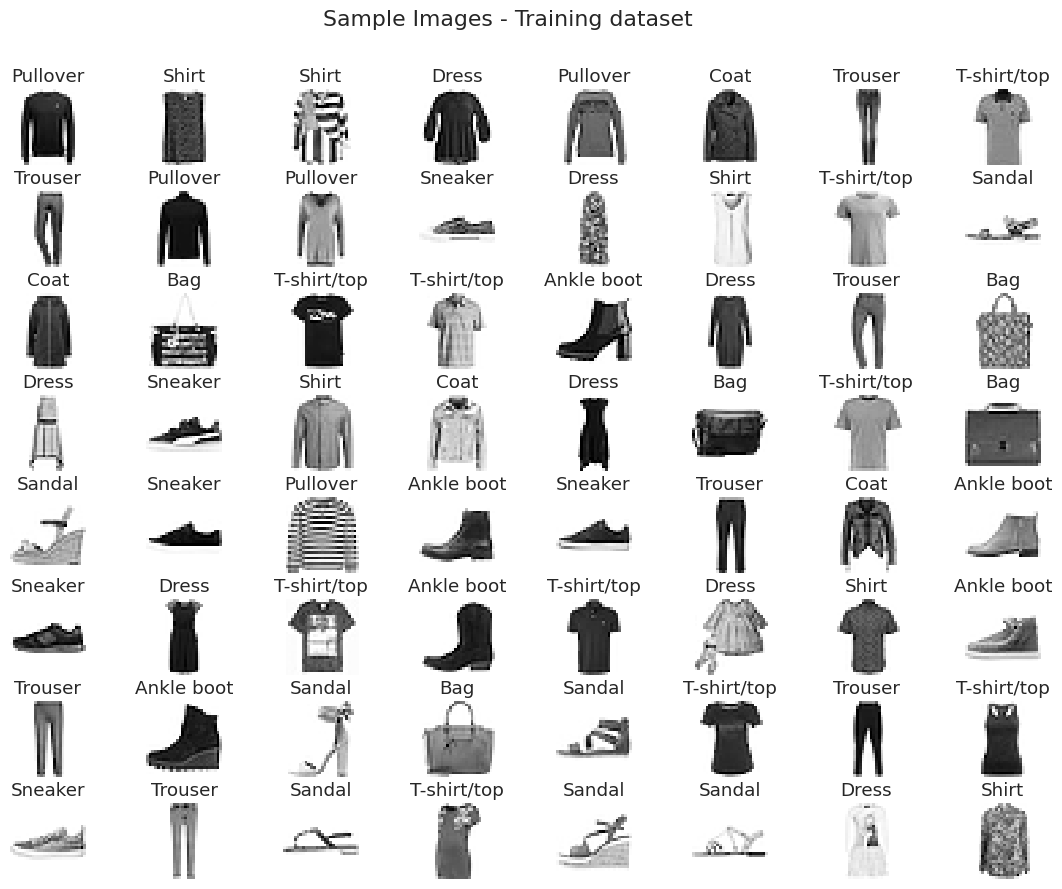

In [7]:
# display a sample
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = next(data_iter)  # fetch first batch of 64 images & labels
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')
#print(f'labels = {labels[:10]}')
display_sample(images.cpu().numpy(), labels.cpu().numpy(), grid_shape=(8, 8),
               plot_title='Sample Images - Training dataset')

## Pytorch Model development

In [8]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 25, 128, 0.001, 0.04
PY_MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'pyt_fashion_mnist_cnn.pyt')
print(f"Model will be saved to {PY_MODEL_SAVE_PATH}")

Model will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn.pyt


In [9]:
class FMNistNet(nn.Module):
    def __init__(self):
        super(FMNistNet, self).__init__()
        self.net = nn.Sequential(
            t3.Conv2d(1, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            t3.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            t3.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            t3.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            t3.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            t3.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.Linear(256*3*3, 1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
model = FMNistNet().to(DEVICE)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
      BatchNorm2d-10          [-1, 128, 14, 14]             256
           Conv2d-11          [-1, 128, 14, 14]         147,584
             ReLU-12          [-1, 128, 14, 14]               0
      BatchNorm2d-13          [-1, 128, 14, 14]             256
        MaxPool2d-14            [-1, 12

## Train the model

In [13]:
loss_fn = nn.CrossEntropyLoss()
metrics_map = {
    "acc": torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
}
trainer = t3.Trainer(
    loss_fn = loss_fn, device=DEVICE, metrics_map = metrics_map,
    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
hist = trainer.fit(model, optimizer, train_dataset, validation_dataset=val_dataset)

Cross training on 'cuda' with 60,000 training and 8,000 cross-validation records...
Epoch ( 1/25): (60000/60000) -> loss: 0.3701 - acc: 0.8649 - val_loss: 0.2708 - val_acc: 0.9027
Epoch ( 2/25): (60000/60000) -> loss: 0.2281 - acc: 0.9164 - val_loss: 0.2729 - val_acc: 0.9034
Epoch ( 3/25): (60000/60000) -> loss: 0.1860 - acc: 0.9317 - val_loss: 0.2430 - val_acc: 0.9157
Epoch ( 4/25): (60000/60000) -> loss: 0.1582 - acc: 0.9423 - val_loss: 0.2152 - val_acc: 0.9251
Epoch ( 5/25): (60000/60000) -> loss: 0.1330 - acc: 0.9514 - val_loss: 0.1999 - val_acc: 0.9294
Epoch ( 6/25): (60000/60000) -> loss: 0.1122 - acc: 0.9587 - val_loss: 0.2427 - val_acc: 0.9256
Epoch ( 7/25): (60000/60000) -> loss: 0.0982 - acc: 0.9645 - val_loss: 0.2231 - val_acc: 0.9327
Epoch ( 8/25): (60000/60000) -> loss: 0.0806 - acc: 0.9710 - val_loss: 0.2489 - val_acc: 0.9316
Epoch ( 9/25): (60000/60000) -> loss: 0.0668 - acc: 0.9757 - val_loss: 0.2628 - val_acc: 0.9326
Epoch (10/25): (60000/60000) -> loss: 0.0547 - acc: 

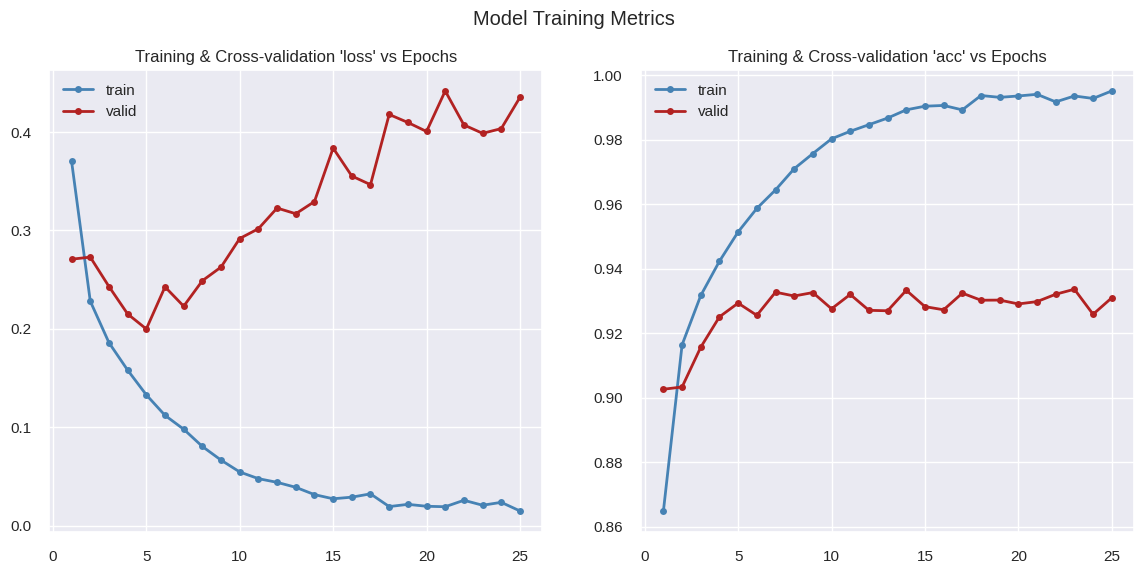

In [13]:
hist.plot_metrics(title = "Model Training Metrics", fig_size = (14, 6))

## Evaluate Performance

In [14]:
# evaluate performance
print('Evaluating model performance...')
metrics = trainer.evaluate(model, train_dataset)
print(f"Training metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, val_dataset)
print(f"Cross-val metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, test_dataset)
print(f"Testing metrics   -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")

Evaluating model performance...
Evaluating (60000/60000) -> loss: 0.0044 - acc: 1.0000('\rEvaluating (60000/60000) -> loss: 0.0129 - acc: 0.9956',)
Training metrics -> loss: 0.0129 - acc: 0.9956
Evaluating (8000/8000) -> loss: 0.3740 - acc: 0.9402('\rEvaluating (8000/8000) -> loss: 0.4334 - acc: 0.9301',)
Cross-val metrics -> loss: 0.4334 - acc: 0.9301
Evaluating (2000/2000) -> loss: 0.3529 - acc: 0.9300('\rEvaluating (2000/2000) -> loss: 0.4077 - acc: 0.9369',)
Testing metrics   -> loss: 0.4077 - acc: 0.9369


### Observations
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---:|
>**Model**|99-100%|93-94%|93-94%| Overfitting

From the table & graphs we observe that:
* The model is significantly overfitting the data - `training accuracy >> cross-val accuracy`
* The training/cross-val loss plots start diverging significantly after the 3-4 th epoch itself
* The gap between `cross-val accuracy` and `test accuracy` is not that much (expected as the samples are drawn randomly from the same distribution)

In [15]:
t3.save_model(model, PY_MODEL_SAVE_PATH)
del model

Pytorch model saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn.pyt


## Making Predictions

In [14]:
model = FMNistNet().to(DEVICE)
t3.load_model(model, PY_MODEL_SAVE_PATH)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)))

Pytorch model loaded from /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn.pyt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
      BatchNorm2d-10          [-1, 128, 14, 14]             256
           Conv2d-11          [-1, 128, 14, 14]         147,584
             ReLU-12          [-1, 128, 14, 14]       

In [15]:
# run predictions
y_pred, y_true = trainer.predict(model, test_dataset)
y_pred = np.argmax(y_pred, axis = 1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions: ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [1 4 5 4 0 8 6 4 7 7 0 1 3 2 5 0 9 0 9 9 3 2 1 6 6 0 0 2 7 2 7 3 6 9 3 4 8 7 9 6 1 2 5 2 8 1 0 4 3 8]
Sample predictions:  [1 4 5 4 0 8 6 4 7 7 0 1 3 2 5 0 9 0 9 9 3 2 1 6 6 0 0 2 7 2 7 3 6 9 3 4 8 7 9 6 1 2 5 2 8 1 0 4 3 8]
We got 136/2000 incorrect!


Displaying sample predictions...


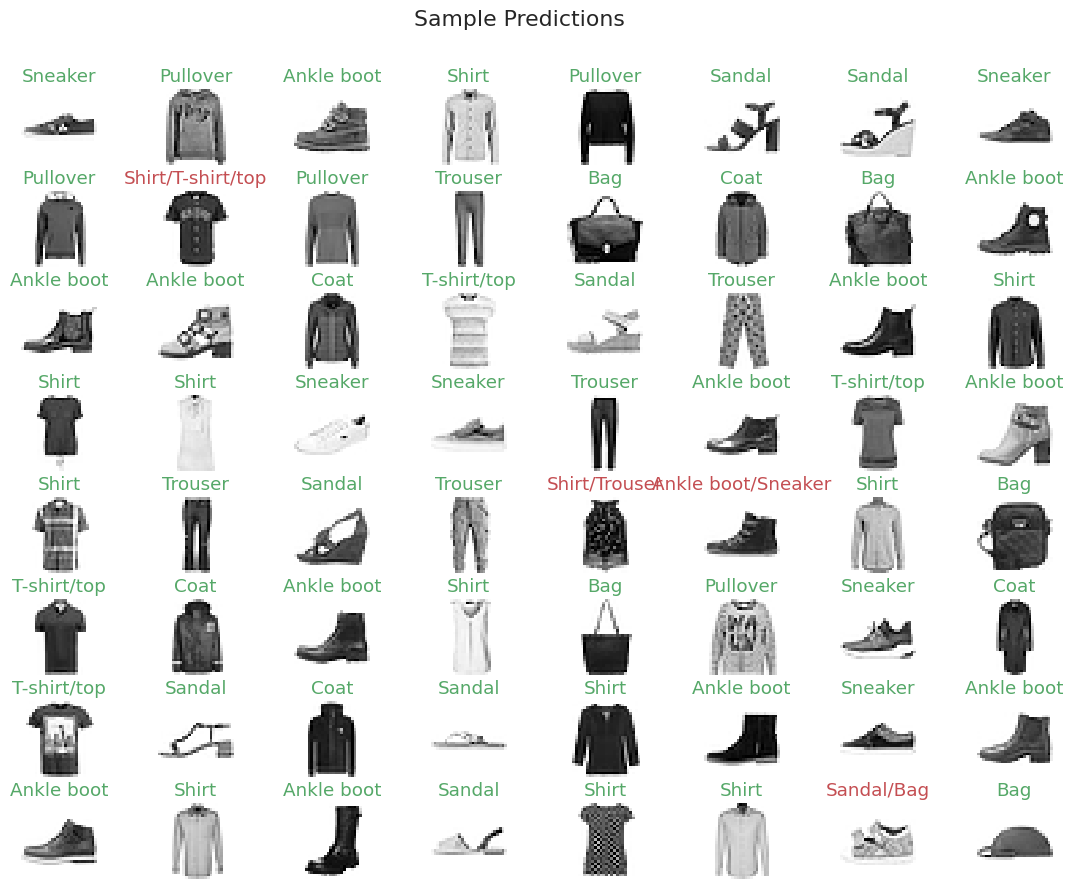

In [16]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 64, shuffle = True
)
data_iter = iter(trainloader)
images, labels = next(data_iter)  # fetch a batch of 64 random images
preds = trainer.predict(model, images)
preds = np.argmax(preds, axis = 1)
display_sample(
    images, labels.numpy(), sample_predictions = preds,
    grid_shape = (8, 8), plot_title = 'Sample Predictions'
)

## Observations
* The base model is significantly overfitting the data
* We get 143/2000 incorrect predictions from test dataset - this is expected, as model is overfitting, so cannot generalize well.

In the next part we will try to reduce the overfitting by implementing 2 types of regularization - Dropout regularization and L2 Regularization. This may reduce the training accuracy of the model, but should reduce the gap between training & cross-val accuracy (i.e. reduce overfitting)

# <center> -- END -- </center>